In [3]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download gpiosenka/sports-classification
unzip -qq sports-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100%|██████████| 424M/424M [00:04<00:00, 107MB/s]


In [2]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf                                                         # load tensorflow
import tensorflow_datasets as tfds

In [3]:
# load dataset - train, test and valid
train=tf.keras.utils.image_dataset_from_directory('train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=128,image_size=(256,256),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='training',seed=8,)
valid=tf.keras.utils.image_dataset_from_directory('train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=128,image_size=(256,256),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='validation',seed=8,)
test=tf.keras.utils.image_dataset_from_directory('test',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                 batch_size=128,image_size=(256,256),shuffle=False,validation_split=0.0,
                                                 interpolation='bilinear',subset=None,seed=8,)
print('Total training images:',train.cardinality()*32)
print('Total validation images:',valid.cardinality()*32)
print('Total test images:',test.cardinality()*32)
training_classes:list=train.class_names
valid_classses:list=valid.class_names
test_classes:list=test.class_names
assert training_classes==valid_classses==test_classes,'class count in train, valid and test set is not same'
print('Class names:',training_classes)

Found 13492 files belonging to 100 classes.
Using 9445 files for training.
Found 13492 files belonging to 100 classes.
Using 4047 files for validation.
Found 500 files belonging to 100 classes.
Total training images: tf.Tensor(2368, shape=(), dtype=int64)
Total validation images: tf.Tensor(1024, shape=(), dtype=int64)
Total test images: tf.Tensor(128, shape=(), dtype=int64)
Class names: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey'

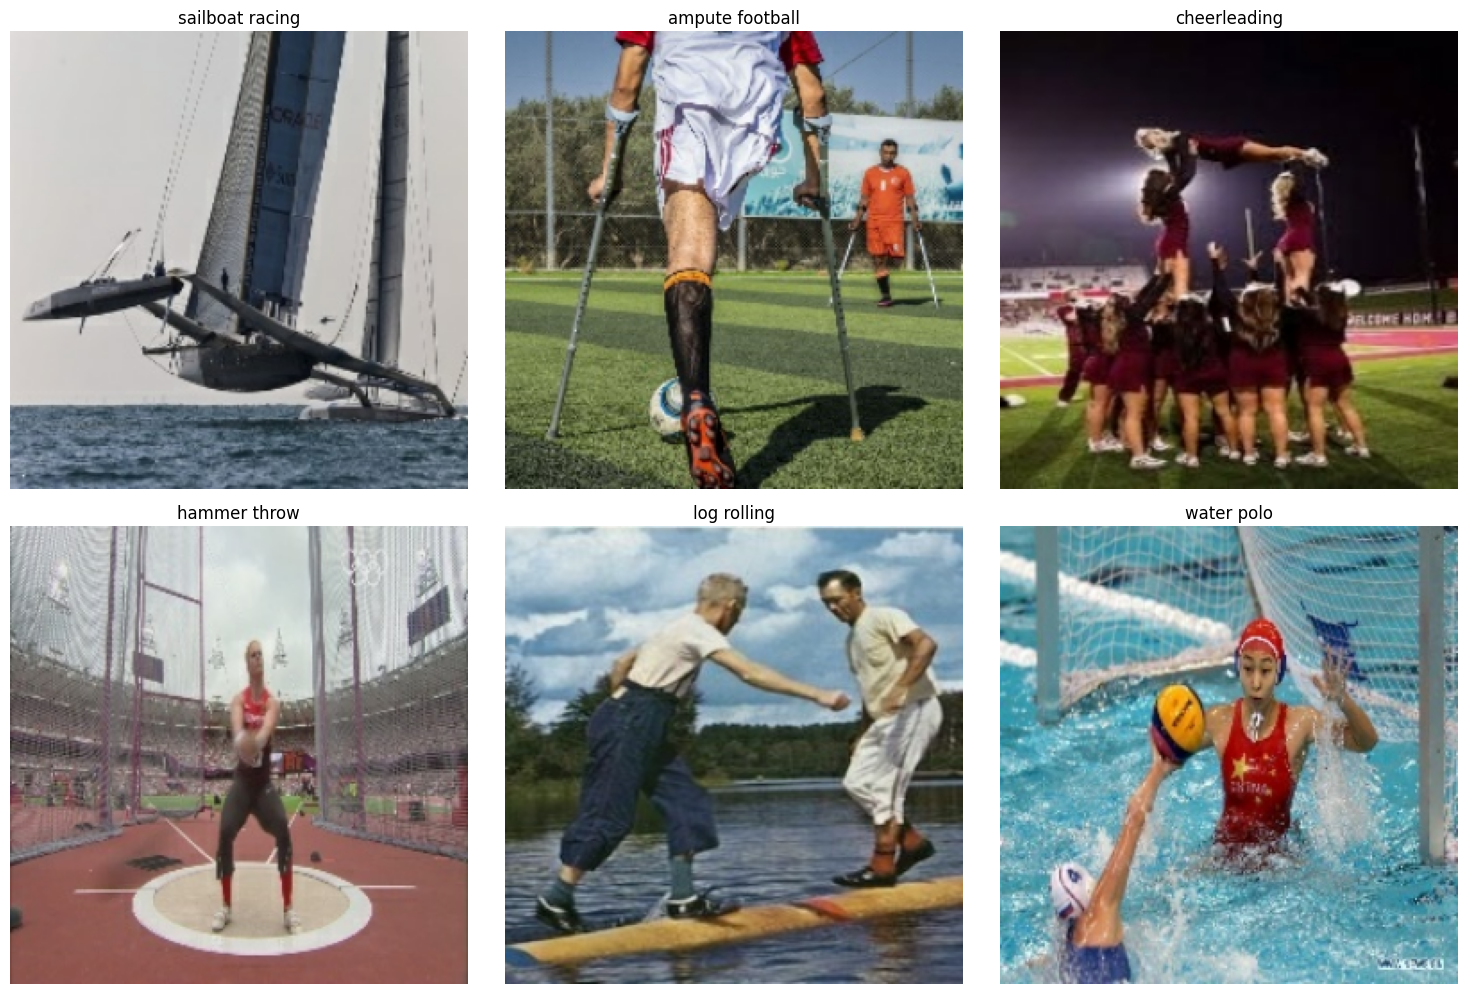

In [4]:
# make plot data training data
for images,labels in train.take(1):break                                        # get a batch of data
images_to_plot:int=6                                                            # number of images to plot
plt.figure(figsize=(15,15))                                                     # figure size
for index in range(images_to_plot):                                             # loop over image index
  plt.subplot(3,3,index+1)                                                      # subplot rows = 3, columns = 3
  plt.imshow(images[index].numpy().astype('uint8'))                             # make plot image
  plt.axis('off')                                                               # make axis off
  plt.title(training_classes[labels[index].numpy()])                            # make add labels as class names
plt.tight_layout()                                                              # adjust layout space
plt.show()

In [5]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)

Maximum pixel values: tf.Tensor(255.0, shape=(), dtype=float32)
Minimum pixel values: tf.Tensor(0.0, shape=(), dtype=float32)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'float32'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int32'>


In [6]:
base_model=tf.keras.applications.Xception(input_shape=(256,256,3),include_top=False,
                                               weights='imagenet',input_tensor=None,pooling=None,classes=1000,
                                               classifier_activation='softmax')

In [7]:
inputs=tf.keras.layers.Input(shape=(256,256,3),batch_size=None,name='model_inputs')# add input layer
model_x=tf.keras.layers.Rescaling(1/255,offset=0.0,name='rescaler')(inputs)     # rescale inputs
model_x=base_model(model_x)                                                     # feed inputs to base model
model_x=tf.keras.layers.Flatten(name='flatten')(model_x)                         # make flatten outputs
model_x=tf.keras.layers.Dense(1024,activation='relu')(model_x)                  # apply dense layer
outputs=tf.keras.layers.Dense(len(training_classes),activation='softmax')(model_x)# output layer
model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_mobilenetv2')     # build model
model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None)# print model summary

Model: "custom_mobilenetv2"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 model_inputs (InputLayer)                            [(None, 256, 256, 3)]                           0                 Y          
                                                                                                                                   
 rescaler (Rescaling)                                 (None, 256, 256, 3)                             0                 Y          
                                                                                                                                   
 xception (Functional)                                (None, 8, 8, 2048)                              20861480          Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [8]:
# make apply data augmentation to data (add more randomness to data)
# source: https://www.tensorflow.org/tutorials/images/data_augmentation
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')# random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')# random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')          # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')# random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]         # make list of data augmentation
# make apply augmentation on training data
for augmentation in augmentations:
  train.map(lambda images,labels: (augmentation(images),labels))                # make apply augmentation

In [9]:
# make compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
# make early stopping
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0,patience=10,verbose=1,mode='auto',restore_best_weights=True)

# make train model
history=model.fit(train,batch_size=128,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=valid,
                  shuffle=True)

Epoch 1/10000


In [ ]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')# make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')# add grid, title and axis labels
plt.show()                                                                      # make plot show

In [23]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')# make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')# add grid, title and axis labels
plt.show()                                                                      # make plot show

NameError: ignored

In [ ]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)                                               # make print results

In [ ]:
# make save model (weights and configuration)
model.save('game_clf_xception',overwrite=True,save_format=None)               # make save

In [24]:
!zip -r -qq "game_clf_xception.zip" "game_clf_xception"                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('game_clf_xception.zip')                                       # download model zip file


zip error: Nothing to do! (try: zip -r -qq game_clf_xception.zip . -i game_clf_xception)


FileNotFoundError: ignored